In [1]:
# Parameters
# Refer to injected parameters for any run.ipynb (similar cell below)
strain = "BY4741"
locus = "FKS1-HS3"
aggdata_outpath = "../../results/df/avg_scores_HS3.csv"

In [2]:
# Parameters
strain = "BY4741"
locus = "FKS1-HS3"
aggdata_outpath = "../../results/df/avg_scores_HS3.csv"


# Notebook to train a Gaussian mixture model

The model is trained on DMS data and used to predict the different classes of mutational effects

## Import libraries

In [3]:
import os
import pandas as pd
from sklearn.mixture import GaussianMixture
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["svg.fonttype"] = "none"

## Specify paths

In [4]:
### Output
classified_outpath = f'../classified/{"_".join([strain,locus])}/'
if not os.path.exists(classified_outpath):
    os.makedirs(classified_outpath)

graph_outpath = "../graphs/"

## Import data

In [5]:
master = pd.read_csv(aggdata_outpath).rename(
    columns={
        "Mutated_seq": "locus",
        "fitness_T2": "s",
        "lower_err_T2": "min_s",
        "upper_err_T2": "max_s",
    }
)
master

,strain,paralog,hotspot,locus,compound,Nham_aa,aa_seq,aa_pos,alt_aa,wt_aa,s,min_s,max_s
0,BY4741,FKS1,HS3,FKS1-HS3,anidulafungin,0,LDTYLWYIIVN,not-applicable,not-applicable,not-applicable,-0.051428,0.015305,0.015305
1,BY4741,FKS1,HS3,FKS1-HS3,anidulafungin,1,*DTYLWYIIVN,690,*,L,-0.202938,0.135180,0.135180
2,BY4741,FKS1,HS3,FKS1-HS3,anidulafungin,1,ADTYLWYIIVN,690,A,L,-0.256719,0.030721,0.030721
3,BY4741,FKS1,HS3,FKS1-HS3,anidulafungin,1,CDTYLWYIIVN,690,C,L,-0.283424,0.223577,0.223577
4,BY4741,FKS1,HS3,FKS1-HS3,anidulafungin,1,EDTYLWYIIVN,690,E,L,0.735617,0.010943,0.010943
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,BY4741,FKS1,HS3,FKS1-HS3,none,1,PDTYLWYIIVN,690,P,L,0.031791,0.004992,0.004992
716,BY4741,FKS1,HS3,FKS1-HS3,none,1,SDTYLWYIIVN,690,S,L,0.003562,0.004580,0.004580
717,BY4741,FKS1,HS3,FKS1-HS3,none,1,TDTYLWYIIVN,690,T,L,0.016197,0.006893,0.006893
718,BY4741,FKS1,HS3,FKS1-HS3,none,1,VDTYLWYIIVN,690,V,L,-0.019327,0.040342,0.040342


## GMM

In [6]:
GMMdf = (
    master[(master.strain == strain) & (master.locus == locus)]
    .groupby(["compound", "aa_seq", "Nham_aa", "aa_pos", "alt_aa", "wt_aa"])[
        ["s", "min_s", "max_s"]
    ]
    .agg(s=("s", "first"), min_s=("min_s", "first"), max_s=("max_s", "first"))
    .reset_index()
)
GMMdf

,compound,aa_seq,Nham_aa,aa_pos,alt_aa,wt_aa,s,min_s,max_s
0,anidulafungin,*DTYLWYIIVN,1,690,*,L,-0.202938,0.135180,0.135180
1,anidulafungin,ADTYLWYIIVN,1,690,A,L,-0.256719,0.030721,0.030721
2,anidulafungin,CDTYLWYIIVN,1,690,C,L,-0.283424,0.223577,0.223577
3,anidulafungin,EDTYLWYIIVN,1,690,E,L,0.735617,0.010943,0.010943
4,anidulafungin,FDTYLWYIIVN,1,690,F,L,0.968660,0.007789,0.007789
...,...,...,...,...,...,...,...,...,...
715,none,PDTYLWYIIVN,1,690,P,L,0.031791,0.004992,0.004992
716,none,SDTYLWYIIVN,1,690,S,L,0.003562,0.004580,0.004580
717,none,TDTYLWYIIVN,1,690,T,L,0.016197,0.006893,0.006893
718,none,VDTYLWYIIVN,1,690,V,L,-0.019327,0.040342,0.040342


### Optimize model

In [7]:
# Set specific seed
seed = 25  # Set value for repetability

# Initialize dictionary to store parameters for each condition
model_dict = {}

# Specify order of conditions
lcomp = ["none", "dox", "anidulafungin", "caspofungin", "micafungin"]

# Optimize model for every condition (here, compound) separately
for j, c in enumerate(lcomp):
    if c in GMMdf.compound.unique():
        # The goal is to minimize AIC and BIC, but mostly BIC
        X = GMMdf[GMMdf.compound == c].s.values.reshape(-1, 1)
        N = np.arange(1, 6)
        models = [None for i in range(len(N))]  # testing up to 1-5 components
        # 5 is the max number of biologically relevant classes: deleterious, WT-like, intermediary, resistant, very resistant
        for i in range(len(N)):
            models[i] = GaussianMixture(n_components=N[i], random_state=seed).fit(
                X, y=None
            )

        # Compute AIC and BIC
        AIC = [m.aic(X) for m in models]
        BIC = [m.bic(X) for m in models]

        # Save parameters to dictionary
        model_dict[c.title()] = (N, AIC, BIC)

In [8]:
model_df = pd.DataFrame.from_dict(
    model_dict, orient="index", columns=["components", "AIC", "BIC"]
).reset_index(names="compound")
model_df = model_df.explode(["components", "AIC", "BIC"]).melt(
    ["compound", "components"], var_name="IC"
)

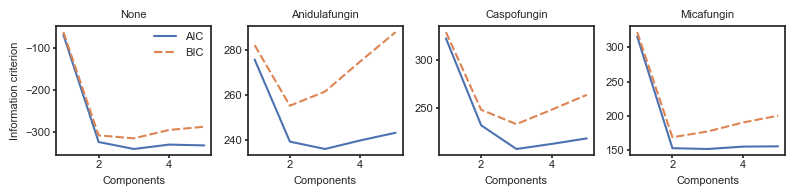

In [9]:
# Purge graph space
sns.set_theme(
    rc={
        "font.family": "Arial",
        "font.size": 8,
        "legend.title_fontsize": 8,
        "legend.fontsize": 8,
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "xtick.major.pad": 2,
        "ytick.major.pad": 2,
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.major.size": 2,
        "ytick.major.size": 2,
    },
    style="ticks",
)

fig = sns.relplot(
    data=model_df,
    col="compound",
    x="components",
    y="value",
    hue="IC",
    style="IC",
    kind="line",
    height=2,
    facet_kws={"sharey": False, "despine": False},
)

fig.set_titles(row_template="{row_name}", col_template="{col_name}")
fig.set_axis_labels("Components", "Information criterion")
sns.move_legend(fig, "upper left", bbox_to_anchor=(0.175, 0.88), title=None)
plt.savefig(
    f'{graph_outpath}/{"_".join([strain,locus])}_GMM_BIC.svg', format="svg", dpi=300
)

In [10]:
for c, y in model_dict.items():  # for each compound
    print(
        c, np.argmin(y[1]) + 1
    )  # display the optimal number of components for the GMM

None 3
Anidulafungin 3
Caspofungin 3
Micafungin 3


### Run model

In [11]:
# Define the number of components (number of mods)
mods = 3

# Define range
mini = round(GMMdf.s.min()) - 1
maxi = round(GMMdf.s.max()) + 1

# Initialize list of df
proba_list = []

for i, c in enumerate(model_dict.keys()):  # For every compound
    X = GMMdf[GMMdf.compound == c.lower()].s.values.reshape(-1, 1)
    M_best = GaussianMixture(n_components=mods, random_state=seed).fit(X, y=None)
    GMMdf.loc[GMMdf.compound == c.lower(), "label"] = M_best.predict(X)

    x = np.linspace(mini, maxi, len(GMMdf[GMMdf.compound == c.lower()]))
    logprob = M_best.score_samples(x.reshape(-1, 1))
    responsibilities = M_best.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    # Convert to dataframe
    indiv_df = pd.DataFrame(pdf_individual)
    indiv_df["x"] = x
    indiv_df = indiv_df.melt(id_vars="x", var_name="label", value_name="p(x)")
    indiv_df["compound"] = c
    proba_list.append(indiv_df)

proba_df = pd.concat(proba_list, ignore_index=True)
hist_df = GMMdf.copy()
hist_df["compound"] = hist_df.compound.apply(lambda x: x.title())

In [12]:
if os.path.exists(f"{classified_outpath}/thresholds.csv"):
    stddf = pd.read_csv(f"{classified_outpath}/thresholds.csv")
else:
    stddf = pd.DataFrame()
    print("Need to calculate thresholds. Will not display in next plot.")

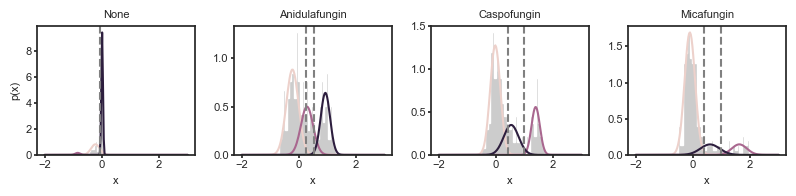

In [13]:
# Purge graph space
sns.set_theme(
    rc={
        "font.family": "Arial",
        "font.size": 8,
        "legend.title_fontsize": 8,
        "legend.fontsize": 8,
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "xtick.major.pad": 2,
        "ytick.major.pad": 2,
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.major.size": 2,
        "ytick.major.size": 2,
    },
    style="ticks",
)

fig = sns.relplot(
    proba_df,
    col="compound",
    x="x",
    y="p(x)",
    hue="label",
    kind="line",
    height=2,
    legend=False,
    facet_kws={"sharey": False, "despine": False},
)

fig.set_titles(row_template="{row_name}", col_template="{col_name}")

for i, c in enumerate(proba_df.compound.unique()):
    fig.axes[0][i].hist(
        hist_df[hist_df.compound == c].s,
        30,
        density=True,
        histtype="stepfilled",
        color=".8",
    )
    if not stddf.empty:
        fig.axes[0][i].axvline(
            x=stddf[stddf.compound == c.lower()].val.tolist()[0], ls="--", color="grey"
        )
        fig.axes[0][i].axvline(
            x=stddf[stddf.compound == c.lower()].val.tolist()[1], ls="--", color="grey"
        )

plt.savefig(
    f'{graph_outpath}/{"_".join([strain,locus])}_GMM_densities.svg',
    format="svg",
    dpi=300,
)

In [14]:
# Looking at the predicted labels for each condition and the mean value to properly convert the label into a class
label_mean = (
    GMMdf.groupby(["compound", "label"])[["s"]]
    .agg(["size", "mean"])
    .reset_index()
    .sort_values(by=[("compound", ""), ("s", "mean")])
)
label_mean

compound label    s          
                        size      mean
0   anidulafungin   0.0   87 -0.232538
1   anidulafungin   1.0   45  0.317354
2   anidulafungin   2.0   48  0.928750
3     caspofungin   0.0  107 -0.018933
5     caspofungin   2.0   35  0.581132
4     caspofungin   1.0   38  1.380829
6      micafungin   0.0  146 -0.097336
8      micafungin   2.0   16  0.707198
7      micafungin   1.0   18  1.615295
10           none   1.0    6 -0.846976
9            none   0.0   49 -0.254824
11           none   2.0  125  0.009636

### Convert classification labels

In [15]:
class_dict = {}
class_list = ["WT-like", "intermediary", "resistant"]
none_list = {
    "FKS1-HS1": ["deleterious", "slightly deleterious", "WT-like"],
    "FKS1-HS2": ["WT-like", "WT-like", "WT-like"],
    "FKS1-HS3": ["deleterious", "slightly deleterious", "WT-like"],
    "FKS2-HS1": ["slightly deleterious", "WT-like", "WT-like"],
    "FKS2-HS2": ["slightly deleterious", "WT-like", "WT-like"],
}
dox_list = {
    "FKS1-HS1": ["deleterious", "slightly deleterious", "WT-like"],
    "FKS2-HS1": ["deleterious", "slightly deleterious", "WT-like"],
    "FKS2-HS2": ["deleterious", "slightly deleterious", "WT-like"],
}

for c in label_mean.compound.unique():
    class_dict[c] = {}

i = 0
for c, l in zip(label_mean.compound, label_mean.label):
    i = len(class_dict[c])
    if c in ["anidulafungin", "caspofungin", "micafungin"]:
        class_dict[c][l] = class_list[i]
    elif c == "none":
        if locus in none_list.keys():
            class_dict[c][l] = none_list[locus][i]
        else:
            class_dict[c][l] = "error"
    elif c == "dox":
        if locus in dox_list.keys():
            class_dict[c][l] = dox_list[locus][i]
        else:
            class_dict[c][l] = "error"
    else:
        class_dict[c][l] = "error"

class_dict

{'anidulafungin': {0.0: 'WT-like', 1.0: 'intermediary', 2.0: 'resistant'},
 'caspofungin': {0.0: 'WT-like', 2.0: 'intermediary', 1.0: 'resistant'},
 'micafungin': {0.0: 'WT-like', 2.0: 'intermediary', 1.0: 'resistant'},
 'none': {1.0: 'deleterious', 0.0: 'slightly deleterious', 2.0: 'WT-like'}}

In [16]:
GMMdf["rclass"] = GMMdf.apply(lambda row: class_dict[row.compound][row.label], axis=1)
GMMdf

,compound,aa_seq,Nham_aa,aa_pos,alt_aa,wt_aa,s,min_s,max_s,label,rclass
0,anidulafungin,*DTYLWYIIVN,1,690,*,L,-0.202938,0.135180,0.135180,0.0,WT-like
1,anidulafungin,ADTYLWYIIVN,1,690,A,L,-0.256719,0.030721,0.030721,0.0,WT-like
2,anidulafungin,CDTYLWYIIVN,1,690,C,L,-0.283424,0.223577,0.223577,0.0,WT-like
3,anidulafungin,EDTYLWYIIVN,1,690,E,L,0.735617,0.010943,0.010943,2.0,resistant
4,anidulafungin,FDTYLWYIIVN,1,690,F,L,0.968660,0.007789,0.007789,2.0,resistant
...,...,...,...,...,...,...,...,...,...,...,...
715,none,PDTYLWYIIVN,1,690,P,L,0.031791,0.004992,0.004992,2.0,WT-like
716,none,SDTYLWYIIVN,1,690,S,L,0.003562,0.004580,0.004580,2.0,WT-like
717,none,TDTYLWYIIVN,1,690,T,L,0.016197,0.006893,0.006893,2.0,WT-like
718,none,VDTYLWYIIVN,1,690,V,L,-0.019327,0.040342,0.040342,2.0,WT-like


In [17]:
GMMdf.to_csv(f"{classified_outpath}/raw_classification.csv")

## Breakdown: number of variants per class

In [18]:
GMMdf = pd.read_csv(f"{classified_outpath}/raw_classification.csv", index_col=0)

In [19]:
GMMdf.groupby(["compound", "rclass"])[["s"]].agg(["size", "median"])

s          
                                   size    median
compound      rclass                             
anidulafungin WT-like                87 -0.215283
              intermediary           45  0.285140
              resistant              48  0.950089
caspofungin   WT-like               107 -0.006547
              intermediary           35  0.554640
              resistant              38  1.425818
micafungin    WT-like               146 -0.113924
              intermediary           16  0.685687
              resistant              18  1.675328
none          WT-like               125  0.012501
              deleterious             6 -0.860735
              slightly deleterious   49 -0.230146

## Refine classification (resolve overlaps)

To resolve overlaps , I use the distributions to define thresholds. However, because only the "resistant" and "WT-like" distributions (as called by the GMM) are narrow, we define the thresholds only for these groups. "Intermediary", "deleterious", etc end up being the label of variants which **did not** cross the thresholds.

### Step 1 - Set thresholds from narrow distributions

In [20]:
zthresh = 2.5  # set threshold in z-score

In [21]:
distri_params = (
    GMMdf.groupby(["compound", "rclass"])[["s"]].agg(["mean", "std"]).reset_index()
)
distri_params.columns = [x[0] if x[1] == "" else x[1] for x in distri_params.columns]
distri_params["lower_bound"] = distri_params["mean"] - zthresh * distri_params["std"]
distri_params["upper_bound"] = distri_params["mean"] + zthresh * distri_params["std"]
distri_params

,compound,rclass,mean,std,lower_bound,upper_bound
0,anidulafungin,WT-like,-0.232538,0.192096,-0.712778,0.247703
1,anidulafungin,intermediary,0.317354,0.151791,-0.062124,0.696832
2,anidulafungin,resistant,0.928750,0.155144,0.540891,1.316609
3,caspofungin,WT-like,-0.018933,0.170992,-0.446413,0.408546
4,caspofungin,intermediary,0.581132,0.187803,0.111625,1.050640
5,caspofungin,resistant,1.380829,0.152970,0.998404,1.763253
6,micafungin,WT-like,-0.097336,0.189515,-0.571123,0.376452
7,micafungin,intermediary,0.707198,0.210230,0.181625,1.232772
8,micafungin,resistant,1.615295,0.260014,0.965260,2.265331
9,none,WT-like,0.009636,0.028933,-0.062697,0.081969


In [22]:
stdlist = []

for c in distri_params.compound.unique():
    if c in ["caspofungin", "micafungin", "anidulafungin"]:
        stdlist.append(
            [
                c,
                "low",
                distri_params.loc[
                    (distri_params.compound == c) & (distri_params.rclass == "WT-like"),
                    "upper_bound",
                ].values[0],
            ]
        )
        if locus in ["FKS1-HS1", "FKS1-HS3", "FKS2-HS1"]:
            stdlist.append(
                [
                    c,
                    "up",
                    distri_params.loc[
                        (distri_params.compound == c)
                        & (distri_params.rclass == "resistant"),
                        "lower_bound",
                    ].values[0],
                ]
            )
        elif locus in ["FKS1-HS2", "FKS2-HS2"]:
            stdlist.append(
                [
                    c,
                    "up",
                    distri_params.loc[
                        (distri_params.compound == c)
                        & (distri_params.rclass == "intermediary"),
                        "upper_bound",
                    ].values[0],
                ]
            )
        else:
            print("Please define locus-specific bound")
    else:
        stdlist.append(
            [
                c,
                "low",
                distri_params.loc[
                    (distri_params.compound == c) & (distri_params.rclass == "WT-like"),
                    "lower_bound",
                ].values[0],
            ]
        )
        stdlist.append([c, "up", None])

stddf = pd.DataFrame(stdlist, columns=["compound", "thresh", "val"])
stddf.to_csv(f"{classified_outpath}/thresholds.csv")
stddf

,compound,thresh,val
0,anidulafungin,low,0.247703
1,anidulafungin,up,0.540891
2,caspofungin,low,0.408546
3,caspofungin,up,0.998404
4,micafungin,low,0.376452
5,micafungin,up,0.965260
6,none,low,-0.062697
7,none,up,NaN


<Axes: xlabel='compound', ylabel='s'>

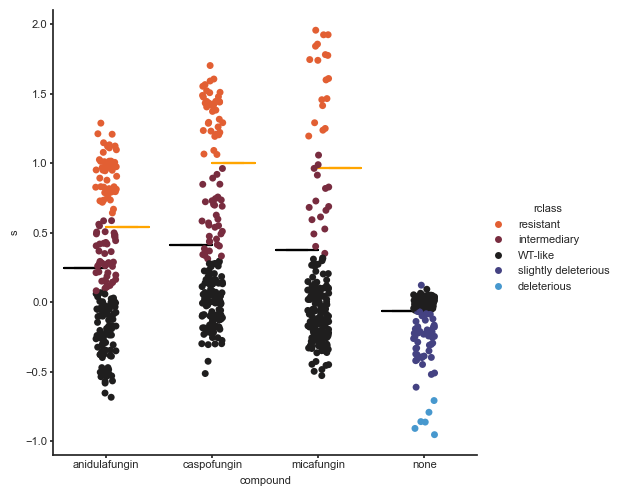

In [23]:
fig = sns.catplot(
    GMMdf,
    x="compound",
    y="s",
    hue="rclass",
    hue_order=[
        "resistant",
        "intermediary",
        "WT-like",
        "slightly deleterious",
        "deleterious",
    ],
    palette="icefire_r",
    # alpha=.3
)

sns.boxplot(
    stddf,
    x="compound",
    y="val",
    hue="thresh",
    hue_order=["low", "up"],
    palette=["black", "orange"],
    fill=False,
    legend=False,
)

### Step 2 - Refine classification

In [24]:
def refine_class(v, comp, threshdf):
    wtbound = threshdf.loc[
        (threshdf.compound == comp) & (threshdf.thresh == "low"), "val"
    ].values[0]
    resbound = threshdf.loc[
        (threshdf.compound == comp) & (threshdf.thresh == "up"), "val"
    ].values[0]

    if (comp in ["none", "dox"]) & (v > -0.7):
        if v >= wtbound:
            return "WT-like"
        else:
            return "slightly deleterious"
    elif (comp in ["none", "dox"]) & (v < -0.7):
        return "deleterious"
    else:
        if v <= wtbound:
            return "WT-like"
        elif v >= resbound:
            return "resistant"
        else:
            return "intermediary"

In [25]:
GMMdf["refined_class"] = GMMdf.apply(
    lambda row: refine_class(row.s, row.compound, stddf), axis=1
)
GMMdf

,compound,aa_seq,Nham_aa,aa_pos,alt_aa,wt_aa,s,min_s,max_s,label,rclass,refined_class
0,anidulafungin,*DTYLWYIIVN,1,690,*,L,-0.202938,0.135180,0.135180,0.0,WT-like,WT-like
1,anidulafungin,ADTYLWYIIVN,1,690,A,L,-0.256719,0.030721,0.030721,0.0,WT-like,WT-like
2,anidulafungin,CDTYLWYIIVN,1,690,C,L,-0.283424,0.223577,0.223577,0.0,WT-like,WT-like
3,anidulafungin,EDTYLWYIIVN,1,690,E,L,0.735617,0.010943,0.010943,2.0,resistant,resistant
4,anidulafungin,FDTYLWYIIVN,1,690,F,L,0.968660,0.007789,0.007789,2.0,resistant,resistant
...,...,...,...,...,...,...,...,...,...,...,...,...
715,none,PDTYLWYIIVN,1,690,P,L,0.031791,0.004992,0.004992,2.0,WT-like,WT-like
716,none,SDTYLWYIIVN,1,690,S,L,0.003562,0.004580,0.004580,2.0,WT-like,WT-like
717,none,TDTYLWYIIVN,1,690,T,L,0.016197,0.006893,0.006893,2.0,WT-like,WT-like
718,none,VDTYLWYIIVN,1,690,V,L,-0.019327,0.040342,0.040342,2.0,WT-like,WT-like


<Axes: xlabel='compound', ylabel='s'>

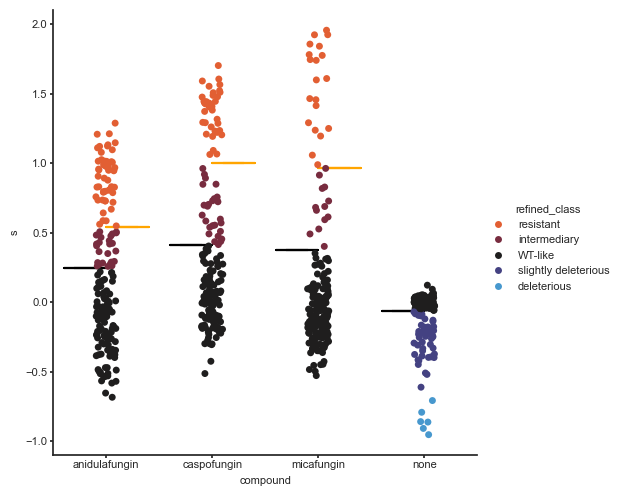

In [26]:
fig = sns.catplot(
    GMMdf,
    x="compound",
    y="s",
    hue="refined_class",
    hue_order=[
        "resistant",
        "intermediary",
        "WT-like",
        "slightly deleterious",
        "deleterious",
    ],
    palette="icefire_r",
    # alpha=.3
)

sns.boxplot(
    stddf,
    x="compound",
    y="val",
    hue="thresh",
    hue_order=["low", "up"],
    palette=["black", "orange"],
    fill=False,
    legend=False,
)

### Step 3 - Collapse classification (sensitive/resistant)

In [27]:
GMMdf["sensres"] = GMMdf.refined_class.replace(
    {
        "intermediary": "resistant",
        "WT-like": "sensitive",
        "slightly deleterious": "sensitive",
        "deleterious": "deleterious",
    }
)
GMMdf

,compound,aa_seq,Nham_aa,aa_pos,alt_aa,wt_aa,s,min_s,max_s,label,rclass,refined_class,sensres
0,anidulafungin,*DTYLWYIIVN,1,690,*,L,-0.202938,0.135180,0.135180,0.0,WT-like,WT-like,sensitive
1,anidulafungin,ADTYLWYIIVN,1,690,A,L,-0.256719,0.030721,0.030721,0.0,WT-like,WT-like,sensitive
2,anidulafungin,CDTYLWYIIVN,1,690,C,L,-0.283424,0.223577,0.223577,0.0,WT-like,WT-like,sensitive
3,anidulafungin,EDTYLWYIIVN,1,690,E,L,0.735617,0.010943,0.010943,2.0,resistant,resistant,resistant
4,anidulafungin,FDTYLWYIIVN,1,690,F,L,0.968660,0.007789,0.007789,2.0,resistant,resistant,resistant
...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,none,PDTYLWYIIVN,1,690,P,L,0.031791,0.004992,0.004992,2.0,WT-like,WT-like,sensitive
716,none,SDTYLWYIIVN,1,690,S,L,0.003562,0.004580,0.004580,2.0,WT-like,WT-like,sensitive
717,none,TDTYLWYIIVN,1,690,T,L,0.016197,0.006893,0.006893,2.0,WT-like,WT-like,sensitive
718,none,VDTYLWYIIVN,1,690,V,L,-0.019327,0.040342,0.040342,2.0,WT-like,WT-like,sensitive


In [28]:
GMMdf.to_csv(f"{classified_outpath}/refined_classification.csv", index=False)